In [14]:
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma, FAISS
from langchain_openai import OpenAIEmbeddings, OpenAI, ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from pprint import pprint
import os

# load_dotenv()
# os.getenv('TEST')
os.chdir('F:\python_stuff\LangChain')

## LLMs vs Chat models
- LLMs in LangChain refer to pure text completion models. The APIs they wrap take a string prompt as input and output a string completion. OpenAI's GPT-3 is implemented as an LLM. 
- Chat models are often backed by LLMs but tuned specifically for having conversations. And, crucially, their provider APIs use a different interface than pure text completion models. Instead of a single string, they take a list of chat messages as input. Usually these messages are labeled with the speaker (usually one of "System", "AI", and "Human"). And they return an AI chat message as output. GPT-4 and Anthropic's Claude-2 are both implemented as chat models.
- Both implement the Runnable interface, the basic building block of the LangChain Expression Language (LCEL). 
- This means they support invoke, ainvoke, stream, astream, batch, abatch, astream_log calls.

In [2]:
# LLM are just sentence completing, output also needs to be parsed for better reading
llm = OpenAI()
llm.invoke('Explain the difference between machine learning, deep learning, and AI')

'\n\nMachine learning, deep learning, and AI are all related concepts that are often used interchangeably, but they have distinct differences.\n\nMachine learning is a subset of AI that involves developing algorithms and statistical models that enable computer systems to learn and improve from data without being explicitly programmed. It relies on large sets of data to train the algorithms and make predictions or decisions based on the patterns and relationships found in the data. Some common machine learning techniques include regression, decision trees, and clustering.\n\nDeep learning is a specific type of machine learning that uses artificial neural networks, which are modeled after the human brain, to process and analyze large amounts of data. Deep learning algorithms can learn and improve on their own by adjusting the parameters of the neural network based on the data they are fed. This allows them to perform complex tasks such as image and speech recognition, natural language pr

In [4]:
for chunk in llm.stream(
    "What are some theories about the number of dimensions in the universe?"
):
    print(chunk, end="", flush=True)



1. String Theory: This theory suggests that the universe is made up of tiny, vibrating strings that exist in 10 dimensions.

2. M-theory: A newer version of string theory, M-theory proposes that there are actually 11 dimensions in the universe.

3. Kaluza-Klein Theory: This theory proposes that there are 5 dimensions in the universe – the three dimensions of space we are familiar with, plus an additional dimension for time, and a fifth dimension that is curled up and too small for us to detect.

4. Brane Theory: This theory suggests that the universe is made up of multiple parallel universes (or branes) that exist in higher-dimensional spaces.

5. Supergravity Theory: This theory combines elements of both general relativity and quantum mechanics and proposes that there are 11 dimensions in the universe.

6. Causal Dynamical Triangulations (CDT): This theory suggests that the universe is made up of four dimensions – three of space and one of time – but that space is fractal and has a 

In [29]:
# Chat models are LLMs backend, but they have a wrapper around them that allows multiple inputs, and outputs, including the speaker persona
llm = ChatOpenAI() 
llm.invoke('Good morning') 

AIMessage(content='Good morning! How can I assist you today?')

### Tracking token usage
Every call within the callback will be traced

In [37]:
from langchain.callbacks import get_openai_callback

with get_openai_callback() as cb:
    for chunk in llm.stream(
        "What are some theories about the number of dimensions in the universe?"
    ):
        print(chunk, end="", flush=True)
    
    usage = cb

usage



1. String Theory: This theory suggests that the universe could have 10 or 11 dimensions, with the additional dimensions being extremely small and beyond our current understanding.

2. Brane Theory: This suggests that the universe may have anywhere from 7 to 11 dimensions, with the extra dimensions being “branes” or membranes that exist in higher-dimensional space.

3. Multiverse Theory: This suggests that the universe could have an infinite number of dimensions, each with their own unique laws of physics.

4. M Theory: This suggests that the universe could have 11 dimensions, with the extra dimensions being “wrapped up” and undetectable to our current understanding.

Tokens Used: 0
	Prompt Tokens: 0
	Completion Tokens: 0
Successful Requests: 0
Total Cost (USD): $0.0

# Retrieval methods

### Load vector database

In [15]:
db = 'Chroma'
collection='earnings'
persist_directory = f'./ignore/{db}/{collection}'

embedding_function = OpenAIEmbeddings(deployment="SL-document_embedder",
                                      model='text-embedding-ada-002') 
if db == 'Chroma':
    vector_db = Chroma(persist_directory=persist_directory, 
                       embedding_function=embedding_function)
elif db == 'FAISS':
    vector_db = FAISS.load_local(persist_directory, embedding_function)

print(vector_db._collection.count())

5


### Basic semantic similarity search, finds k most similar queries

In [10]:
# query it
query = "How is AI eating the world?"
docs = vector_db.similarity_search(query, k=2)
print(f'Number of matches: {len(docs)}')

Number of matches: 2


In [12]:
vector_db.similarity_search_with_relevance_scores('How is AI eating the world?')

[(Document(page_content="E3 AI getting hit in early morning  trading on Thursday in response to the  company's disappointing earnings results  here's everything you need to know about  this business in about 10 minutes my  name is Brian faldi as the time is  recording I do not own shares of C3 AI  ticker shimble AI a $3.5 billion company  Revenue this quarter grew 177% that was  an acceleration to 73.2 million however  that missed wall Street's estimate  although was within the midpoint of  Management's guidance range uh earnings  per share on an adjusted basis were -13  cents that was worse than the year ago  period although was better than wall  Street's uh estimate mixed results at  best but the disappointing Revenue  guidance is not a good sign for  investors uh margins are horrible  horrible across the board down on a  gross operating and net margin basis  we'll get to why this is happening in  just a little bit free cash flow year to  date year-to dates so for the last six  month

### Maximum marginal relevance, finds fetch_k most similar results, then get k most diverse results

In [16]:
query = "What is the meaning of a Subscription economy? Give an example"
docs = vector_db.max_marginal_relevance_search(query, k=2, fetch_k=4)
print(f'Number of matches: {len(docs)}')
for doc in docs:
    pprint(doc.page_content)

Number of matches: 2
('the goal of business should be to start with the wants and needs of a '
 'particular customer base, then create a service that delivers ongoing value '
 'to those customers. The idea was to turn customers into subscribers in order '
 'to develop recurring revenue. I called the context for this change the '
 'Subscription Economy. Oh man, did I get a lot of crap for that article. '
 'There were comments like: Do you really think we don’t get it, Tien? That we '
 'don’t understand the difference between a product and a')
('Today the whole world runs “as a service”: transportation, education, media, '
 'health care, connected devices, retail, industry. Subscriptions themselves, '
 'of course,aren’t new. The most basic definition of a subscription is simply '
 'a piece of writing beneath a document (sub script): a name, a note, an '
 'addendum. When two parties are involved, that constitutes a mutual '
 'agreement, an accord, a relationship. As a business model, subs

### Self query
This method allows the the query to be processed as both
- semantic search for context
- and also a filter search onto the metadata

In [1]:
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain_community.vectorstores import Chroma


docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]

vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

In [13]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain_openai import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]

document_content_description = "Brief summary of a movie"
model = ChatOpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    model,
    vectorstore,
    document_content_description,
    metadata_field_info,
    verbose=True, 
    enable_limit=True # This allows the self query to also identify limit from the query
)

retriever.get_relevant_documents("One Animated film")

[Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]

In [10]:
retriever.get_relevant_documents("Give me two movies that came after year two thousand")

[Document(page_content='A bunch of normal-sized women are supremely wholesome and some men pine after them', metadata={'director': 'Greta Gerwig', 'rating': 8.3, 'year': 2019}),
 Document(page_content='Leo DiCaprio gets lost in a dream within a dream within a dream within a ...', metadata={'director': 'Christopher Nolan', 'rating': 8.2, 'year': 2010})]

# Question answering with semantic search + LLM

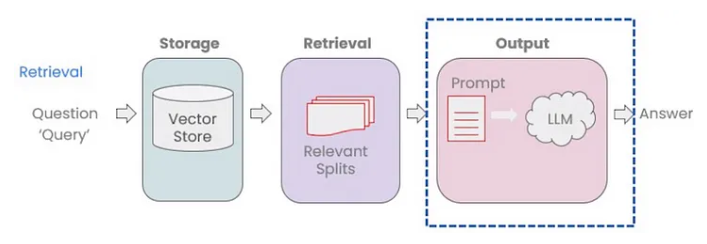

### Without using a customized prompt

In [8]:
model_name = 'gpt-3.5-turbo-1106'
llm = ChatOpenAI(model_name=model_name, temperature=0)


qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever = vector_db.as_retriever(),
    return_source_documents=True
)

query = "What are major topics for this book?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('The major topics for this book include how subscriptions are transforming '
 'different industries, tactical and operational details on applying the '
 'subscription model across all aspects of a company, industry benchmarks, '
 'relevant case studies, best practices, and guidance on transitioning a '
 'traditionally product-based company to a subscription-based revenue model.')

----------Printing source documents-----------------

Total of 4 sources
('for a basic playbook on making the shift to recurring revenue. While '
 'subscriptions have been getting a huge amount of press coverage lately, I’m '
 'going to give you the most important material, the stone tablets. In Part 1 '
 'of this book we’ll explore how subscriptions are transforming several '
 'different industries, and in Part 2 we’ll dig into more tactical, '
 'operational details about how to apply the subscription model across every '
 'aspect of your company. Here are some of the topics I’ll be')

('businesses I want t

In [9]:
query = "Did the author explain his story?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('Yes, the author explained the importance of starting with a foundational '
 'thesis or a bigger reason to exist when telling a business story. The author '
 'also emphasized the significance of understanding the context of the company '
 'within the broader commercial world before delving into the product story.')

----------Printing source documents-----------------

Total of 4 sources
('companies (especially ones here in Silicon Valley) have a pretty good grasp '
 'of the first two stories. They know what they’re selling, and who’s buying. '
 'They have nice scrolling websites filled with all sorts of product features '
 'and client case studies. But lots of them are missing a foundational thesis. '
 'A bigger reason to exist. They don’t have a why (much less a why now ). And '
 'that’s the story you should really be starting with. In a perfect world, '
 'these stories are actually heard in a')

('We were excited about our business. Things were going well, and we had an '
 'aggress

In [15]:
help(vector_db.as_retriever)

Help on method as_retriever in module langchain.schema.vectorstore:

as_retriever(**kwargs: 'Any') -> 'VectorStoreRetriever' method of langchain.vectorstores.chroma.Chroma instance
    Return VectorStoreRetriever initialized from this VectorStore.
    
    Args:
        search_type (Optional[str]): Defines the type of search that
            the Retriever should perform.
            Can be "similarity" (default), "mmr", or
            "similarity_score_threshold".
        search_kwargs (Optional[Dict]): Keyword arguments to pass to the
            search function. Can include things like:
                k: Amount of documents to return (Default: 4)
                score_threshold: Minimum relevance threshold
                    for similarity_score_threshold
                fetch_k: Amount of documents to pass to MMR algorithm (Default: 20)
                lambda_mult: Diversity of results returned by MMR;
                    1 for minimum diversity and 0 for maximum. (Default: 0.5)
 

### With a chained prompt

In [43]:
model_name = 'gpt-3.5-turbo-1106'
llm = ChatOpenAI(model_name=model_name, temperature=1)

# Build prompt
template = """Use the following pieces of context to answer the question at the end. \
If you don't know the answer, just say that you don't know, don't try to make up an answer. \
Context: {context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vector_db.as_retriever(
        search_type="similarity", # mmr, similarity_score_threshold, similarity
        search_kwargs = {
            "k": 3,                     #k: Amount of documents to return (Default: 4)
            'score_threshold': 0.5,     # Minimum relevance threshold for similarity_score_threshold
            'fetch_k': 5,              # Amount of documents to pass to MMR algorithm (Default: 20)
            'lambda_mult': 0.5,         # Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum. (Default: 0.5)
            #'filter': {'source':'GPT-4 Technical Report'} #Filter by document metadata'search'
            }
        ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
    )

with get_openai_callback() as cb:
    query = "Is the investment thesis on track for NVIDIA? Give me reasons. Also tell me about the lurking risks. How does this compare to other companies?"
    result = qa_chain({"query": query})
    pprint(result["result"])
    print()
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")

('Yes, the investment thesis for NVIDIA is on track. The company has shown '
 'strong growth in revenue and profit margins, with data center revenue nearly '
 'quadrupling and operating expenses only up 16% despite tripling in revenue. '
 'The company also has a strong balance sheet, with over 8 billion in net cash '
 'and a high net profit margin of over 55% on a non-gaap basis. Additionally, '
 'NVIDIA is returning billions to shareholders and has a wide moat with '
 'expanding opportunities for its products.\n'
 '\n'
 'However, there are lurking risks, specifically in terms of valuation. The '
 'stock is trading at a very high PE ratio and price to free cash flow, '
 'indicating high expectations priced into the stock. This high valuation is a '
 'result of investors pricing in expectations of 27% growth in free cash flow '
 'every year for the next 10 years, which is a high hurdle to maintain over a '
 'long period.\n'
 '\n'
 "Compared to other companies, NVIDIA's strong financial 

In [35]:
print(f"Total of {len(result['source_documents'])} sources")
print('\n----------Printing source documents-----------------\n')
for document in result['source_documents']:
    print(document.page_content)
    print(document.metadata)
    print()

Total of 4 sources

----------Printing source documents-----------------

imagine this scenario with me for a  minute you go into a classroom of  college students you tell them there's a  $ 1.2 trillion company that is growing  its Topline by over 200% it is doubling  its profit margins it is Raising its  Outlook moving forward first of all that  is something that no company of this  size has ever done before but then you  tell them after all these great results  come in after they raise the Outlook the  stock is down on the news yes that's  actually what happened first time that a  company at this scale has done this and  shares of Nvidia which reported its  earnings last night are actually down  over 3% as of right now so why is this  happening and what does it mean for  investors we'll get into that over the  next 10 minutes my name is Brian stoel  as of the time of this recording I do  not own shares of Nvidia want to give a  shout out to why charts for sponsoring  today's video mo

# There are other ready available retrievers, such as from Wikipedia
This will send API calls backend. The alternative is to use its loader, and load + split the pages to store ourselves

In [40]:
from langchain.retrievers import WikipediaRetriever
from pprint import pprint

wiki_retriever = WikipediaRetriever(
    top_k_results = 4,
    lang= "en", 
    load_all_available_meta = False,
    doc_content_chars_max = 10000
    )

docs = wiki_retriever.get_relevant_documents(query="Transformers learning")
pprint(docs)

[Document(page_content='A transformer is a deep learning architecture based on the multi-head attention mechanism. It is notable for not containing any recurrent units, and thus requires less training time than previous recurrent neural architectures, such as long short-term memory (LSTM), and its later variation has been prevalently adopted for training large language models on large (language) datasets, such as the Wikipedia corpus and Common Crawl.\nInput text is split into n-grams encoded as tokens and each token is converted into a vector via looking up from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism allowing the signal for key tokens to be amplified and less important tokens to be diminished. Though the transformer paper was published in 2017, the softmax-based attention mechanism was proposed in 2014 for machine translation, and the Fast

## Attempt to build the chain myself using LangChain Expression Language (LCEL)

In [15]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

template = """Tell me a lame joke about {topic}.
Speak in the manner of a {persona}.
{message}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

# Pipe the components into each otehr. | here is like a UNIX pipe
chain = prompt | model | StrOutputParser()

result = chain.invoke(
    {'topic' : "Technology", 
     'persona': 'child', 
     'message': 'Add a follow up joke'})
print(result)

Why did the computer go to school?

Because it wanted to become a "byte" student!

Follow up joke:

Why did the smartphone take a day off?

Because it needed a "cellfie" break!


# RAG with LCEL
This is achieved by adding one more layer in front of the previous chain.
- Runnable Parallel will let us define multiple values and operations to run in parallel
- The invoked text will be sent here and passed to both retriever and RunnablePassthrough (just passed through)
- these two will enter the prompt template

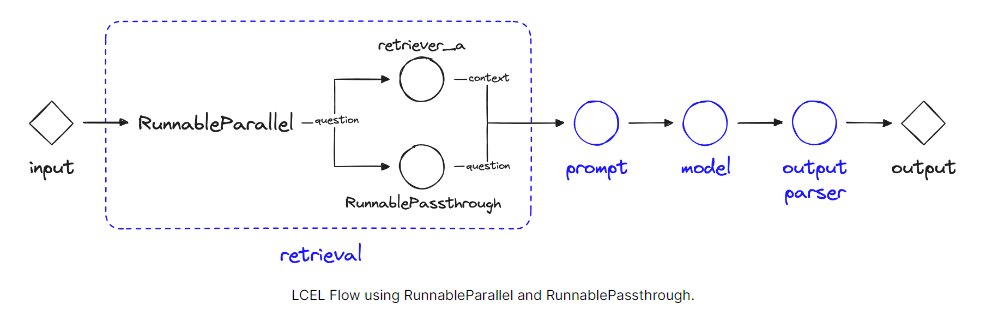

https://www.pinecone.io/learn/series/langchain/langchain-expression-language/

In [7]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

In [28]:
model = ChatOpenAI(temperature=1)
retriever = vector_db.as_retriever(
    search_type="similarity", # mmr, similarity_score_threshold, similarity
        search_kwargs = {"k": 1}
)

context_prompt = '''
Given this context {context}
Answer the following question: {question}
Answer:
'''
retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)

prompt = ChatPromptTemplate.from_template(context_prompt)

rag_chain = retrieval | prompt | model | StrOutputParser()
answer = rag_chain.invoke('Explain what NVIDIA do?')
pprint(answer)

('NVIDIA is a company that specializes in designing and manufacturing graphics '
 'processing units (GPUs) and system-on-a-chip units (SoCs) for various '
 'applications. They are known for their high-performance GPUs that are used '
 'in gaming, data centers, artificial intelligence, and autonomous vehicles, '
 "among other fields. NVIDIA's GPUs are used to enhance the visual experience "
 'in video games, accelerate scientific research, power machine learning '
 'algorithms, and support advanced graphics in various industries. '
 'Additionally, NVIDIA offers software and development tools to support their '
 'hardware products.')


# Conversational Chain

In [3]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

llm = ChatOpenAI()
conversation = ConversationChain(llm=llm, memory=ConversationBufferMemory())

In [4]:
conversation.invoke('I need your help, what time is it of the day?')

{'input': 'I need your help, what time is it of the day?',
 'history': '',
 'response': 'It is currently 2:35 p.m.'}

In [5]:
conversation.invoke('My timezone is GMT+8')

{'input': 'My timezone is GMT+8',
 'history': 'Human: I need your help, what time is it of the day?\nAI: It is currently 2:35 p.m.',
 'response': 'In that case, it would be 10:35 p.m. in your timezone.'}

In [8]:
for chunk in conversation.stream('What is the timezone that you are using'):
    print(chunk.get('response'))

I apologize for the confusion. As an AI, I don't have a physical location or a specific timezone. However, I am programmed to use Coordinated Universal Time (UTC) as a reference for time-related information.


# Conversational Retrieval Chain

In [22]:
from langchain.schema import format_document
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_core.runnables import RunnableParallel

# First need to summarise the history and create a standalone question using the LLM
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""

CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=1)
    | StrOutputParser(),
)

# Our invoke will pipe both 'question' and 'chat_history' through a model to condense the question
_inputs.invoke({'question' : 'How did the company do for the latest earnings?', 
                'chat_history': [ HumanMessage(content="What does NVDA do?"), 
                                 AIMessage(content="NVIDIA is a company that specializes in designing and manufacturing graphics.")]})

# This will be further piped to the retriever etc

{'standalone_question': 'How did NVIDIA do for the latest earnings?'}

In [20]:
# Next part is similar to a normal RAG, the difference is in the context pipe, we will pipe in the standalone_question

retriever = vector_db.as_retriever(
    search_type="similarity", # mmr, similarity_score_threshold, similarity
    search_kwargs = {"k": 1}
)

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

_context = {
    "context": itemgetter("standalone_question") | retriever ,
    "question": lambda x: x["standalone_question"],
}

# Putting all together
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI()
output = conversational_qa_chain.invoke({'question' : 'How did the company do for the latest earnings?', 
                                        'chat_history': [ HumanMessage(content="What does NVDA do?"), 
                                                        AIMessage(content="NVIDIA is a company that specializes in designing and manufacturing graphics.")]})
pprint(output.content)

('NVIDIA performed well in its latest earnings. Its revenue more than tripled '
 "to $18 billion, which exceeded Wall Street's and Management's guidance. "
 'Earnings per share on a non-GAAP basis increased more than 7x to $48, also '
 "surpassing Wall Street's estimate. The company saw significant growth in its "
 'data center and gaming segments, with data center revenue nearly quadrupling '
 'and gaming revenue increasing by 81%. Gross margins, operating margins, and '
 'net margins all more than doubled. The company also returned $4 billion to '
 'shareholders and provided strong guidance for the next quarter. However, '
 'despite these positive results, the stock price declined due to high '
 'valuation.')


# Adding memory

In [28]:
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import RunnableLambda

memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)
# memory = ConversationBufferMemory()
# memory.__dict__

In [42]:
# First we add a step to load memory
# This adds a "memory" key to the input object
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)

final_chain = loaded_memory | _inputs | _context | ANSWER_PROMPT | ChatOpenAI()
input = {'question': 'How did NVDA do as a company?'}
result = final_chain.invoke(input)
pprint(result.content)

('Based on the given context, the performance of NVDA as a company was '
 "impressive. The company's revenue more than tripled to $18 billion, "
 "exceeding Wall Street's expectations. The earnings per share on a non-gaap "
 'basis increased by more than 7x. The company experienced significant growth '
 'in its data center revenue and gaming segment. Additionally, the gross '
 'margin expanded, operating and net margins more than doubled, and free cash '
 'flow increased. NVDA returned $4 billion to shareholders and had a net cash '
 'balance of over $8 billion. Overall, the company demonstrated strong '
 'financial results and growth.')


In [47]:
# We need to manually save the  (input and output), this will be improved in the future
memory.save_context(input, {"answer": result.content})
memory.load_memory_variables([])

{'history': [HumanMessage(content='How did NVDA do as a company?'),
  AIMessage(content="Based on the given context, the performance of NVDA as a company was impressive. The company's revenue more than tripled to $18 billion, exceeding Wall Street's expectations. The earnings per share on a non-gaap basis increased by more than 7x. The company experienced significant growth in its data center revenue and gaming segment. Additionally, the gross margin expanded, operating and net margins more than doubled, and free cash flow increased. NVDA returned $4 billion to shareholders and had a net cash balance of over $8 billion. Overall, the company demonstrated strong financial results and growth.")]}

In [48]:
input = {'question': 'What is the thesis now?'}
result = final_chain.invoke(input)
pprint(result.content)

('The current thesis for NVDA is that it is a high-quality company with high '
 'expectations baked into its stock price. Its recent earnings report was '
 'positive, but the stock is down due to its valuation being considered '
 'expensive compared to historical levels. The company has a strong financial '
 'performance, with tripled revenue, doubled profit margins, and significant '
 "growth in various segments. However, the stock's decline is attributed to "
 'concerns about its high valuation and the need for sustained high growth '
 'rates to justify the current price.')


In [49]:
# We need to manually save the  (input and output), this will be improved in the future
memory.save_context(input, {"answer": result.content})
memory.load_memory_variables([])

{'history': [HumanMessage(content='How did NVDA do as a company?'),
  AIMessage(content="Based on the given context, the performance of NVDA as a company was impressive. The company's revenue more than tripled to $18 billion, exceeding Wall Street's expectations. The earnings per share on a non-gaap basis increased by more than 7x. The company experienced significant growth in its data center revenue and gaming segment. Additionally, the gross margin expanded, operating and net margins more than doubled, and free cash flow increased. NVDA returned $4 billion to shareholders and had a net cash balance of over $8 billion. Overall, the company demonstrated strong financial results and growth."),
  HumanMessage(content='What is the thesis now?'),
  AIMessage(content="The current thesis for NVDA is that it is a high-quality company with high expectations baked into its stock price. Its recent earnings report was positive, but the stock is down due to its valuation being considered expensive

In [50]:
input = {'question': 'What should I look out for as an investor?'}
result = final_chain.invoke(input)
pprint(result.content)

('As an investor, you should be cautious about the following factors when '
 'considering NVDA as an investment:\n'
 '\n'
 "1. Valuation: The stock's valuation is considered expensive, with a high PE "
 'ratio and a high price-to-free cash flow ratio compared to historical '
 'levels. This suggests that the stock may be overpriced.\n'
 '\n'
 '2. Market expectations: The market has high expectations for NVDA, and the '
 "stock's performance is influenced by meeting or exceeding those "
 'expectations. Any failure to meet these expectations could result in a '
 'negative impact on the stock price.\n'
 '\n'
 '3. Revenue growth sustainability: While NVDA has experienced impressive '
 'revenue growth, there is a possibility that this growth may slow down in the '
 "future. As an investor, you should monitor the company's ability to sustain "
 'and continue its revenue growth trajectory.\n'
 '\n'
 "4. Dependence on data centers: A significant portion of NVDA's revenue comes "
 'from data cen